In [1]:
import datetime as dt
import warnings
from datetime import date

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

warnings.filterwarnings('ignore')

from gs_quant.instrument import InflationSwap
from gs_quant.markets import HistoricalPricingContext
from gs_quant.markets.portfolio import Portfolio
from gs_quant.risk import IRFwdRate
from gs_quant.data import Dataset
from gs_quant.datetime import business_day_offset, business_day_count
from gs_quant.api.fred.data import FredDataApi
from gs_quant.timeseries import correlation, std, diff
from gs_quant.common import PayReceive, Currency

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
from gs_quant.session import GsSession

# external users should substitute their client id and secret; please skip this step if using internal jupyterhub
GsSession.use(client_id=None, client_secret=None, scopes=('run_analytics', 'read_product_data'))

In this notebook, we will focus on inflation curves. Using macro economic drivers such as rates, equities, credit and oil, we will analyse trends and compare pre and post Covid-19 pandemic relationships. This is an example of the GS Quant functionalities and it is not a recommendation of a trade in the instruments discussed, please follow up with your salesperson to discuss specific implementations.

* [1 - Define a few function and inputs](#1---Define-a-few-functions-and-inputs)
* [2 - Build the inflation portfolio](#2---Build-the-inflation-portfolio)
* [3 - Retrieve macro drivers data](#3---Retrieve-macro-drivers-data)
* [4 - Carry](#4---Carry)
* [5 - Correlation to macro drivers](#5---Correlation-to-macro-drivers)
* [6 - Actual vs Predicted](#6---Actual-vs-Predicted)

## 1 - Define a few functions and inputs

Let's start by defining a few handy functions and inputs to improve readability of the notebook. The functions created here help with handling date offsets and rolling of trades, aggregating the portfolio at the instrument level rather than leg level (which proves useful for the curves), and finally computing correlations and multi-factor linear regressions.

In [3]:
def roll_forward_1y(trade):
    '''
    Roll the trade 1y
    For forward starting trade decrease the fwd start
    For spot starting roll the tenor
    '''
    fwd, tenor = trade[-2:]
    tenor = int(tenor[:-1])
    if fwd is None:
        trade[-1] = '{}y'.format(tenor - 1)
    else:
        fwd = int(fwd[:-1])
        trade[-2] = '{}y'.format(fwd - 1)
    return trade


def date_subtract_period_str(ref_date, period):  
    '''
    Substract 1y/m/d to a fixed date
    '''
    time_letter = period[-1]
    num = int(period[:-1])

    if time_letter == 'd':
        past_date = ref_date - dt.timedelta(days=num)
    elif time_letter == 'm':
        past_date = date(ref_date.year, ref_date.month - num, ref_date.day)
    else:  
        past_date = date(ref_date.year - num, ref_date.month, ref_date.day)

    return past_date


def create_inflation_swap(trade):
    '''
    Create an inflation swap from
    name, CCY, pay/receive, fwd start
    and tenor input
    '''
    trade_name, ccy, payrec, fwd, tenor = trade
    return InflationSwap(pay_or_receive=payrec, termination_date=tenor, notional_currency=ccy, effective_date=fwd,
                         name=trade_name)


def negate_leg(col):
    '''
    In order to aggregate price for the flatteners we need to negate
    the receive leg
    '''
    instr = col.name
    if 'flattener' in instr.name and instr.pay_or_receive == PayReceive.Receive:
        return -col
    return col
    

def negate_carry(port, series):
    '''
    In order to aggregate carry for the flatteners we need to negate
    carry numbers for the receive leg
    '''
    mask = port.to_frame()['pay_or_receive'] == PayReceive.Receive  
    return series.where(mask.array, -series)


def flip_flatteners(prices):
    '''
    When computing correlation we flip prices for the flatteners to visualise 
    numbers as if we were putting on the trade
    '''
    flipped_p = prices
    if 'flattener' in prices.name:
        flipped_p = prices * (-1)
    return flipped_p


def correl_map(drivers_df, prices_df, start_date):
    '''
    Compute correlation of returns between two timeseries from a specific date 
    '''
    start_date = business_day_offset(start_date, 0, roll='preceding')
    drivers_diff = diff(drivers_df[drivers_df.index > start_date])
    prices_diff = diff(prices_df[prices_df.index > start_date])

    correl_df = pd.DataFrame(index=prices_df.columns, columns=drivers_df.columns)
    for x in range(len(drivers_df.columns)):
        for y in range(len(prices_df.columns)):
            correl = correlation(drivers_diff.iloc[:, x], prices_diff.iloc[:, y], type_='returns')
            correl_df.iloc[y, x] = correl.iloc[-1]

    return correl_df


def regression(y, x, regr_start, regr_end, select_x=False):
    '''
    Compute a multi-factors linear regression of y on a subset of x
    '''
    y = y.loc[regr_start:regr_end]
    x = x.loc[regr_start:regr_end]
    if select_x:
        x = x[select_x]

    x = sm.add_constant(x)  # adding a constant
    model = sm.OLS(y, x).fit()

    return model


def regr_prediction(y, x, regr_start, regr_end, predict_start, predict_end=None, select_x=False):
    '''
    Compute a multi-factors linear regression of y on a subset of x between regr_start and regr_end
    and return predictions vs actuals for y from predict_start to predict_end
    '''
    model = regression(y, x, regr_start, regr_end, select_x=select_x)
    y_actual = y.loc[slice(predict_start, predict_end)]
    x_actual = x.loc[slice(predict_start, predict_end)]
    
    prediction = model.predict(sm.add_constant(x_actual))
    prediction.name = 'Predicted'

    return pd.DataFrame([y_actual, prediction]).T


today = date.today()

start_date = business_day_offset(date(2015, 11, 1), 0, roll='following')
end_date = business_day_offset(today, -1, roll='preceding')

regr_start = date(2018, 10, 1)
regr_end = date(2019, 10, 1)

## 2 - Build the inflation portfolio

let's build a portfolio of inflation swaps and curves, then retrieve historical rates.

In [4]:
trades_info = (
    ['2y2y HICP', Currency.EUR, PayReceive.Receive, '2y', '2y'],
    ['5y5y HICP', Currency.EUR, PayReceive.Receive, '5y', '5y'],
    ['5s20s HICP flattener', Currency.EUR, PayReceive.Receive, None, '5y'],
    ['5s20s HICP flattener', Currency.EUR, PayReceive.Pay, None, '20y'],
    ['10s30s HICP flattener', Currency.EUR, PayReceive.Receive, None, '10y'],
    ['10s30s HICP flattener', Currency.EUR, PayReceive.Pay, None, '30y'],
    ['5y5y/10y10y HICP flattener', Currency.EUR, PayReceive.Receive, '5y', '5y'],
    ['5y5y/10y10y HICP flattener', Currency.EUR, PayReceive.Pay, '10y', '10y'],
)

infla_port = Portfolio(map(create_inflation_swap, trades_info), name = 'inflation swaps')
infla_df = infla_port.to_frame()
infla_df.index = infla_df.index.droplevel(0)
infla_df.fillna('default')

,asset_class,type,effective_date,fee,notional_currency,pay_or_receive,termination_date
instrument,,,,,,,
2y2y HICP (InflationSwap),AssetClass.Rates,AssetType.InflationSwap,2y,0,Currency.EUR,PayReceive.Receive,2y
5y5y HICP (InflationSwap),AssetClass.Rates,AssetType.InflationSwap,5y,0,Currency.EUR,PayReceive.Receive,5y
5s20s HICP flattener (InflationSwap),AssetClass.Rates,AssetType.InflationSwap,default,0,Currency.EUR,PayReceive.Receive,5y
5s20s HICP flattener (InflationSwap),AssetClass.Rates,AssetType.InflationSwap,default,0,Currency.EUR,PayReceive.Pay,20y
10s30s HICP flattener (InflationSwap),AssetClass.Rates,AssetType.InflationSwap,default,0,Currency.EUR,PayReceive.Receive,10y
10s30s HICP flattener (InflationSwap),AssetClass.Rates,AssetType.InflationSwap,default,0,Currency.EUR,PayReceive.Pay,30y
5y5y/10y10y HICP flattener (InflationSwap),AssetClass.Rates,AssetType.InflationSwap,5y,0,Currency.EUR,PayReceive.Receive,5y
5y5y/10y10y HICP flattener (InflationSwap),AssetClass.Rates,AssetType.InflationSwap,10y,0,Currency.EUR,PayReceive.Pay,10y


In [5]:
with HistoricalPricingContext(start_date, end_date, is_batch=True, csa_term='EUR-OIS'):
    port_hist_rate = infla_port.calc(IRFwdRate)

prices = pd.DataFrame(port_hist_rate)
prices.index = infla_port.instruments
prices_T = prices.T.apply(negate_leg)
prices_T.columns = [instr.name for instr in infla_port.instruments]
prices_T = prices_T.groupby(level=0, axis=1, sort=False).sum()
prices_T *= 1e4
prices_T.tail()

,2y2y HICP,5y5y HICP,5s20s HICP flattener,10s30s HICP flattener,5y5y/10y10y HICP flattener
2020-11-11,85.58,118.12,43.50,41.75,39.26
2020-11-12,83.83,116.29,42.82,41.13,38.61
2020-11-13,81.97,114.61,42.14,41.06,38.91
2020-11-16,84.71,116.03,39.75,39.32,37.92
2020-11-17,81.40,114.16,40.50,39.63,38.10


## 3 - Retrieve macro drivers data


For this analysis we use rates, credit and equities data from [Marquee data catalog](https://marquee.gs.com/s/discover/data-services/catalog) and oil data from [FRED](https://fred.stlouisfed.org/). You will need to use your own FRED API key. See [here](https://research.stlouisfed.org/useraccount/login/secure/) to create one (takes under a minute). 

In [6]:
FRED_API_KEY = 'YOUR_KEY_HERE'
fred_API = FredDataApi(api_key=FRED_API_KEY)
fred_pull = fred_API.build_query(start=start_date, end=end_date)

drivers = {
    'Rates': {'instr': ['EUR', 'GBP', 'USD'], 'tenor': ['10y', '30y']},
    'Credit': {'instr': ['Xover', 'CDX_IG'], 'tenor': ['5y']},
    'Equities': ['SPX', 'SX5E'],
    'Commodities': ['WTI']
}

dataset_map = {
    'Rates': {'id': 'IR_SWAP2', 'value': 'rate'},
    'Credit': {'id': 'CDSLEVELS', 'value': 'spread'},
    'Equities': {'id': 'TREOD', 'value': 'closePrice'},  
    'Commodities': 'fred'
}

id_map = {
    'EUR': 'MA5WM2QWRVMYKDK0',
    'GBP': 'MABXTJXXN8WJR7R8',
    'USD': 'MAAXGV0GZTW4GFNC',
    'Xover': 'MA67A5J6SPG8F7R6',
    'CDX_IG': 'MANJG63BKCNEHYW3',
    'SX5E': 'MA4B66MW5E27U8P32SY',
    'SPX': 'MA4B66MW5E27U8P32SB',
    'WTI': 'DCOILWTICO'
}
id_map_inv = {v: k for k, v in id_map.items()}

df_list = []

for asset_type, assets in drivers.items():
    ds_info = dataset_map[asset_type]
    
    if ds_info == 'fred':  
        sub_df = pd.DataFrame(fred_API.query_data(fred_pull, dataset_id=id_map['WTI']))
        sub_df.columns = ['WTI']

    else:  
        col = ['instr name']

        if asset_type in ['Rates', 'Credit']:
            id_keys = assets['instr']
            kwargs = {'tenor': assets['tenor']}
            col.append('tenor')
            separator = '_'
        else:
            id_keys = assets
            kwargs = {}
            separator = ''

        asset_ids = [id_map[x] for x in id_keys]
        raw_data = Dataset(ds_info['id']).get_data(start_date, end_date, assetId=asset_ids, **kwargs)
        raw_data['instr name'] = raw_data.apply(lambda x: id_map_inv[x['assetId']], axis=1)
        sub_df = pd.pivot_table(raw_data, values=ds_info['value'], index=['date'], columns=col)
        sub_df.columns = sub_df.columns.map(separator.join)

    df_list.append(sub_df)

drivers_df = pd.concat(df_list, axis=1)
drivers_df = drivers_df.fillna(method='ffill').dropna()

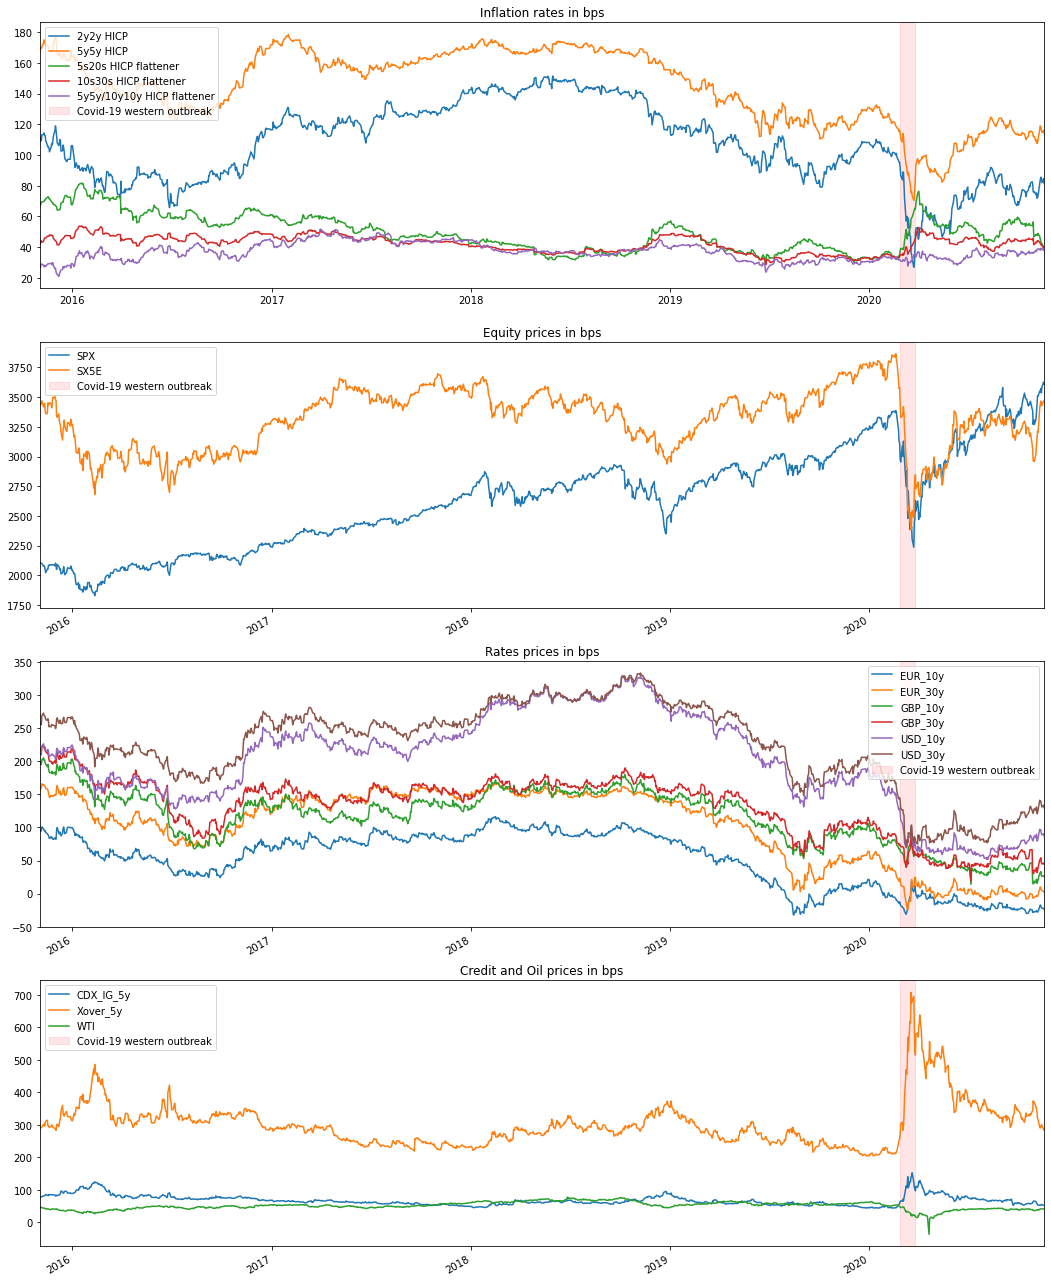

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(18, 25))
label = 'Covid-19 western outbreak'
prices_T.plot(title='Inflation rates in bps', ax=ax1) 
ax1.axvspan(date(2020, 2, 27), date(2020, 3, 26), color='red', alpha=0.1, label=label)
ax1.legend(loc='upper left')

drivers_df[['SPX', 'SX5E']].plot(title='Equity prices in bps', ax=ax2)
ax2.axvspan(date(2020, 2, 27), date(2020, 3, 26), color='red', alpha=0.1, label=label)
ax2.xaxis.label.set_visible(False)
ax2.legend(loc='upper left')

rates = drivers_df[['EUR_10y', 'EUR_30y', 'GBP_10y', 'GBP_30y', 'USD_10y', 'USD_30y']] * 1e4
rates.plot(title='Rates prices in bps', ax=ax3)
ax3.axvspan(date(2020, 2, 27), date(2020, 3, 26), color='red', alpha=0.1, label=label)
ax3.xaxis.label.set_visible(False)
ax3.legend()

drivers_df[['CDX_IG_5y', 'Xover_5y', 'WTI']].plot(title='Credit and Oil prices in bps', ax=ax4)
ax4.axvspan(date(2020, 2, 27), date(2020, 3, 26), color='red', alpha=0.1, label=label)
ax4.xaxis.label.set_visible(False)
ax4.legend()

plt.show()

## 4 - Carry

Let's compute 3 months carry and vol adjusted carry using 3m realised volatility. Here we assume linearity of the roll over the year thus compute 3m roll based on 1y roll.

In [8]:
infla_port.resolve()
base_rate = infla_port.to_frame()['fixed_rate']

roll_port = Portfolio(map(lambda x: create_inflation_swap(roll_forward_1y(x)), trades_info), name='inflation swaps roll fwd')
roll_port.resolve()
fwd_rate = roll_port.to_frame()['fixed_rate']

In [24]:
carry_df = pd.concat([pd.DataFrame(base_rate.values,columns=['Base']), pd.DataFrame(fwd_rate.values,columns=['Roll Fwd'])], axis=1)
carry_df['1y Carry'] = negate_carry(infla_port, carry_df['Roll Fwd'] - carry_df['Base'])
carry_df['3m Carry (bps)'] = carry_df['1y Carry'] * 1e4 / 4
carry_df.index = [instr.name for instr in infla_port.instruments]
carry_df = carry_df.groupby(level=0, sort=False).sum()

back_3m = date(today.year, today.month - 3, today.day)
infla_diff = diff(prices_T[prices_T.index > back_3m])
infla_vol = infla_diff.apply(lambda x: std(x))
vol_3m = infla_vol.iloc[-1] * np.sqrt(business_day_count(back_3m, today))

carry_df['3m Vol-adjusted Carry ratio in %'] = carry_df['3m Carry (bps)'] / vol_3m * 100
carry_df.reset_index(inplace=True)

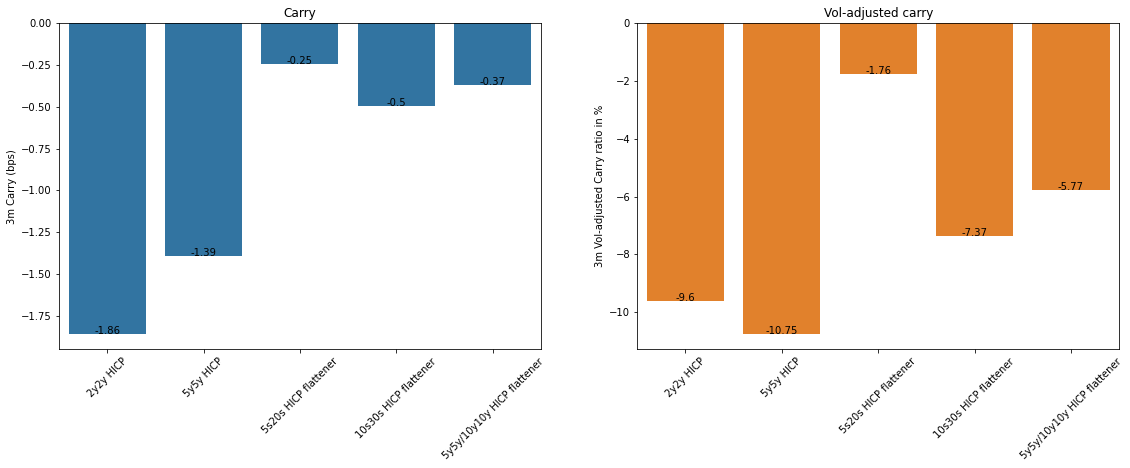

In [25]:
clr_palette = sns.color_palette()

f,(ax_b1, ax_b2) = plt.subplots(1, 2, figsize=(19, 6))

ax_b1.tick_params('x', labelrotation=45)
ax_b2.tick_params('x', labelrotation=45)
ax_b1.set_title('Carry')
ax_b2.set_title('Vol-adjusted carry')

b1 = sns.barplot(x='index', y='3m Carry (bps)', data=carry_df, ax=ax_b1, palette=[clr_palette[0]])
for index, row in carry_df.iterrows():
    b1.text(index, row['3m Carry (bps)'], round(row['3m Carry (bps)'],2), color='black', ha="center")
    
b1.xaxis.set_label_text('')
b2 = sns.barplot(x='index', y='3m Vol-adjusted Carry ratio in %', data=carry_df, ax=ax_b2, palette=[clr_palette[1]])
for index, row in carry_df.iterrows():
    b2.text(index, row['3m Vol-adjusted Carry ratio in %'], round(row['3m Vol-adjusted Carry ratio in %'], 2), color='black', ha="center")
b2.xaxis.set_label_text('')

plt.show()

## 5 - Correlation to macro drivers

Now we look at the correlations between inflation rates and our macro series over various timeframes. From a trade's perspective, a flattening move should be positively correlated to an equity rally and bond sell-off. To correct for the directional bias of flattening, we to flip the curves' direction in the correlation calculations in order to keep the correlation sign accurante.

In [11]:
correl_str = ['3m','1y','3y','5y']
correl_start_dates = [date_subtract_period_str(today, t) for t in correl_str]

flipped_prices = prices_T.apply(flip_flatteners)
drivers_df.index = drivers_df.index.date
correl_matrices = [correl_map(drivers_df, flipped_prices, x) for x in correl_start_dates] 

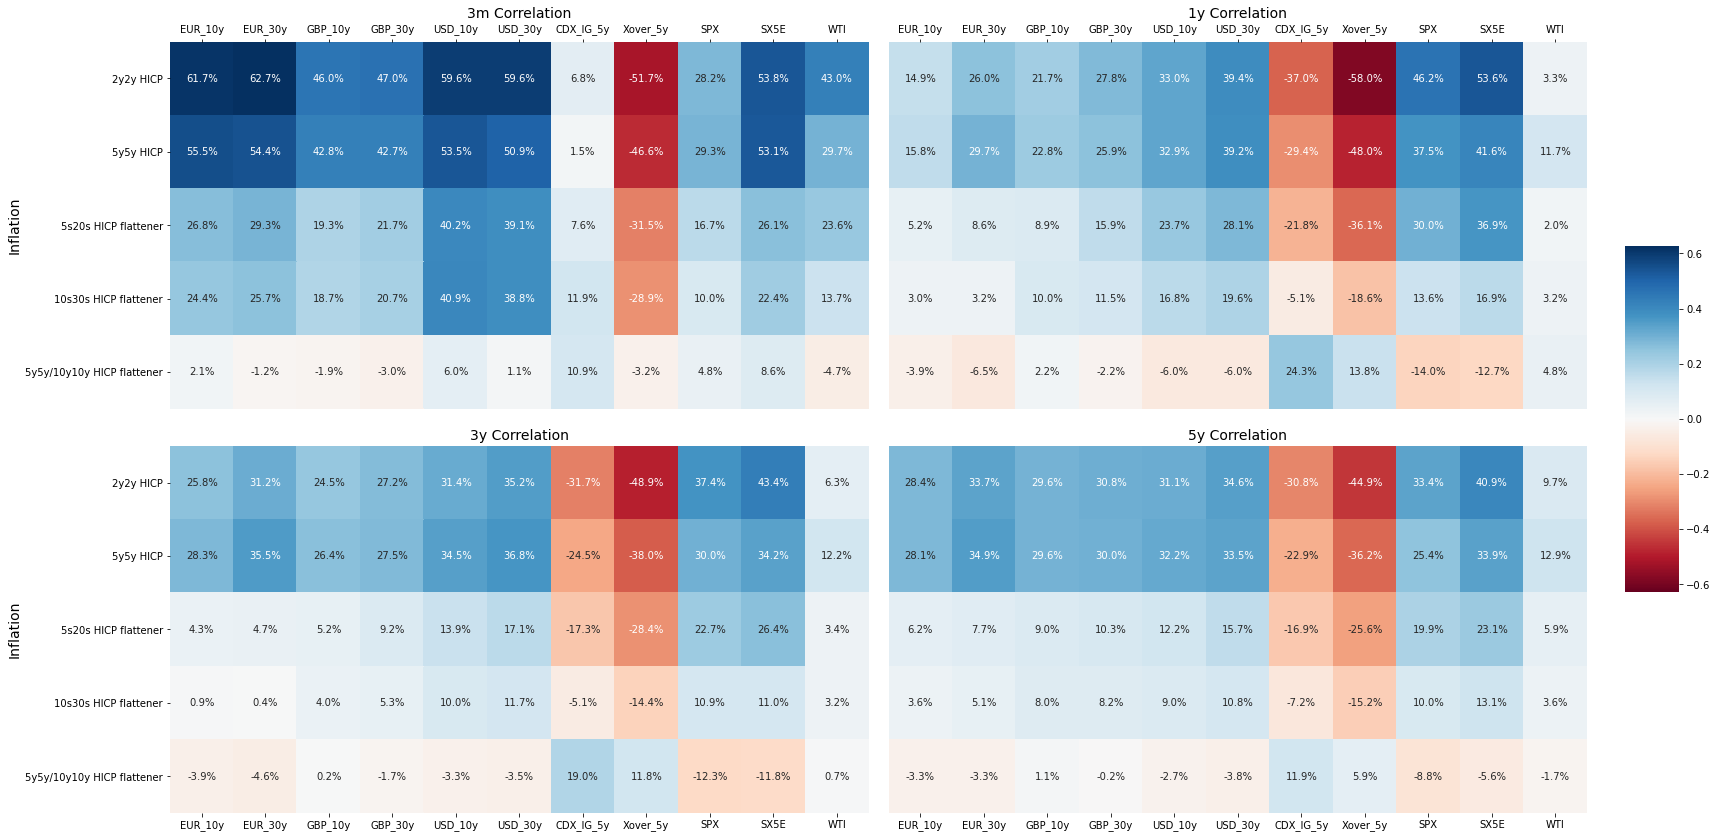

In [12]:
fig, axn = plt.subplots(2, 2, figsize=(25, 12))
cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])
lim = max([np.nanmax(abs(mat)) for mat in correl_matrices])

for i, ax in enumerate(axn.flat):
    g = sns.heatmap(correl_matrices[i].apply(pd.to_numeric), ax=ax,
                    cbar=i == 0,
                    vmin=-lim, vmax=lim, center=0,
                    annot=True, cmap='RdBu', fmt='.1%',
                    cbar_ax=None if i else cbar_ax)
    ax.set_title('{} Correlation'.format(correl_str[i]), fontsize=14)
    if i % 2 == 0:
        ax.set_ylabel('Inflation', fontsize=14)
    else:
        ax.axes.get_yaxis().set_visible(False)
    if i // 2 == 0:
        ax.xaxis.tick_top()

fig.tight_layout(rect=[0, 0, 0.9, 1], pad=2)

## 6 - Actual vs Predicted

Finally, we run a multifactors linear regression on our macro drivers using pre-covid data. 
We then visualise where we would have expected inflation rates to be, given previously determined pre-covid relationship, versus where they are now.

In [13]:
regr_data = pd.concat([drivers_df, prices_T],axis=1).fillna(method='ffill').dropna() # to ensure same data for both drivers and inflation
regr_drivers = regr_data[['EUR_10y', 'EUR_30y', 'Xover_5y', 'SPX', 'SX5E', 'WTI']]
regr_infla = regr_data[list(prices_T.columns)]

In [14]:
pred = {}
for x in regr_infla.columns:
    pred[x] = regr_prediction(regr_infla[x], regr_drivers, regr_start=regr_start, regr_end=regr_end, predict_start=regr_start)['Predicted']
pred_df = pd.DataFrame.from_dict(pred, orient='columns')
pred_df.columns = pred_df.columns + ' pred'

df = regr_infla[regr_infla.index > dt.date(2019, 1, 1)].join(pred_df)

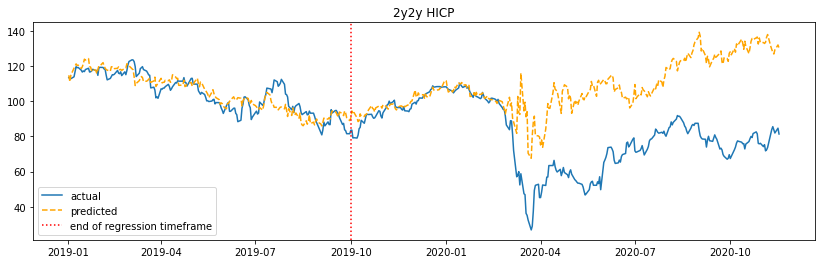

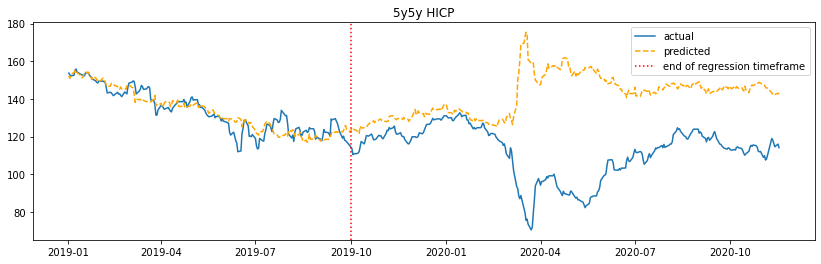

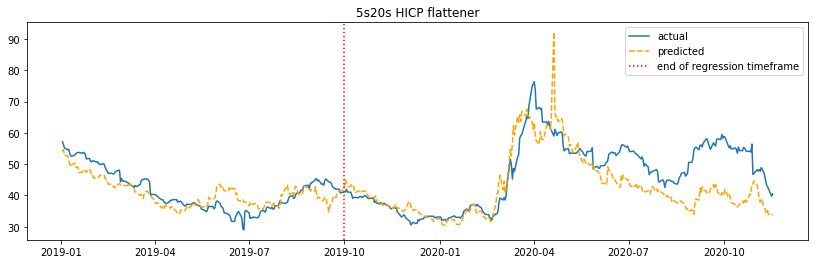

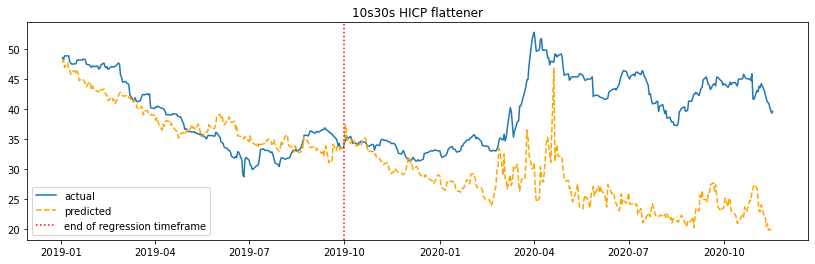

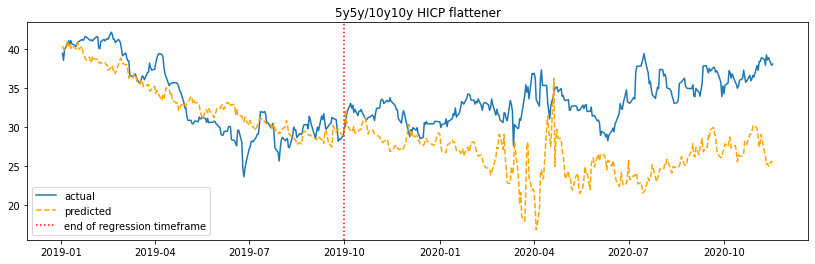

In [15]:
for x in regr_infla.columns:
    fig,ax = plt.subplots(figsize=(14, 4))
    ax.plot(df[[x]], label='actual')
    ax.plot(df[[x + ' pred']], color="orange", linestyle='--', label='predicted')
    plt.axvline(x=regr_end, linestyle=':', color='red', label='end of regression timeframe')
    ax.set_title(x)
    ax.legend()

### Disclaimers

Indicative Terms/Pricing Levels: This material may contain indicative terms only, including but not limited to pricing levels. There is no representation that any transaction can or could have been effected at such terms or prices. Proposed terms and conditions are for discussion purposes only. Finalized terms and conditions are subject to further discussion and negotiation.
www.goldmansachs.com/disclaimer/sales-and-trading-invest-rec-disclosures.html If you are not accessing this material via Marquee ContentStream, a list of the author's investment recommendations disseminated during the preceding 12 months and the proportion of the author's recommendations that are 'buy', 'hold', 'sell' or other over the previous 12 months is available by logging into Marquee ContentStream using the link below. Alternatively, if you do not have access to Marquee ContentStream, please contact your usual GS representative who will be able to provide this information to you.
Backtesting, Simulated Results, Sensitivity/Scenario Analysis or Spreadsheet Calculator or Model: There may be data presented herein that is solely for illustrative purposes and which may include among other things back testing, simulated results and scenario analyses. The information is based upon certain factors, assumptions and historical information that Goldman Sachs may in its discretion have considered appropriate, however, Goldman Sachs provides no assurance or guarantee that this product will operate or would have operated in the past in a manner consistent with these assumptions. In the event any of the assumptions used do not prove to be true, results are likely to vary materially from the examples shown herein. Additionally, the results may not reflect material economic and market factors, such as liquidity, transaction costs and other expenses which could reduce potential return.
OTC Derivatives Risk Disclosures: 
Terms of the Transaction: To understand clearly the terms and conditions of any OTC derivative transaction you may enter into, you should carefully review the Master Agreement, including any related schedules, credit support documents, addenda and exhibits. You should not enter into OTC derivative transactions unless you understand the terms of the transaction you are entering into as well as the nature and extent of your risk exposure. You should also be satisfied that the OTC derivative transaction is appropriate for you in light of your circumstances and financial condition. You may be requested to post margin or collateral to support written OTC derivatives at levels consistent with the internal policies of Goldman Sachs. 

Liquidity Risk: There is no public market for OTC derivative transactions and, therefore, it may be difficult or impossible to liquidate an existing position on favorable terms. Transfer Restrictions: OTC derivative transactions entered into with one or more affiliates of The Goldman Sachs Group, Inc. (Goldman Sachs) cannot be assigned or otherwise transferred without its prior written consent and, therefore, it may be impossible for you to transfer any OTC derivative transaction to a third party. 

Conflict of Interests: Goldman Sachs may from time to time be an active participant on both sides of the market for the underlying securities, commodities, futures, options or any other derivative or instrument identical or related to those mentioned herein (together, "the Product"). Goldman Sachs at any time may have long or short positions in, or buy and sell Products (on a principal basis or otherwise) identical or related to those mentioned herein. Goldman Sachs hedging and trading activities may affect the value of the Products. 

Counterparty Credit Risk: Because Goldman Sachs, may be obligated to make substantial payments to you as a condition of an OTC derivative transaction, you must evaluate the credit risk of doing business with Goldman Sachs or its affiliates. 

Pricing and Valuation: The price of each OTC derivative transaction is individually negotiated between Goldman Sachs and each counterparty and Goldman Sachs does not represent or warrant that the prices for which it offers OTC derivative transactions are the best prices available, possibly making it difficult for you to establish what is a fair price for a particular OTC derivative transaction; The value or quoted price of the Product at any time, however, will reflect many factors and cannot be predicted. If Goldman Sachs makes a market in the offered Product, the price quoted by Goldman Sachs would reflect any changes in market conditions and other relevant factors, and the quoted price (and the value of the Product that Goldman Sachs will use for account statements or otherwise) could be higher or lower than the original price, and may be higher or lower than the value of the Product as determined by reference to pricing models used by Goldman Sachs. If at any time a third party dealer quotes a price to purchase the Product or otherwise values the Product, that price may be significantly different (higher or lower) than any price quoted by Goldman Sachs. Furthermore, if you sell the Product, you will likely be charged a commission for secondary market transactions, or the price will likely reflect a dealer discount. Goldman Sachs may conduct market making activities in the Product. To the extent Goldman Sachs makes a market, any price quoted for the OTC derivative transactions, Goldman Sachs may differ significantly from (i) their value determined by reference to Goldman Sachs pricing models and (ii) any price quoted by a third party. The market price of the OTC derivative transaction may be influenced by many unpredictable factors, including economic conditions, the creditworthiness of Goldman Sachs, the value of any underlyers, and certain actions taken by Goldman Sachs. 

Market Making, Investing and Lending: Goldman Sachs engages in market making, investing and lending businesses for its own account and the accounts of its affiliates in the same or similar instruments underlying OTC derivative transactions (including such trading as Goldman Sachs deems appropriate in its sole discretion to hedge its market risk in any OTC derivative transaction whether between Goldman Sachs and you or with third parties) and such trading may affect the value of an OTC derivative transaction. 

Early Termination Payments: The provisions of an OTC Derivative Transaction may allow for early termination and, in such cases, either you or Goldman Sachs may be required to make a potentially significant termination payment depending upon whether the OTC Derivative Transaction is in-the-money to Goldman Sachs or you at the time of termination. Indexes: Goldman Sachs does not warrant, and takes no responsibility for, the structure, method of computation or publication of any currency exchange rates, interest rates, indexes of such rates, or credit, equity or other indexes, unless Goldman Sachs specifically advises you otherwise.
Risk Disclosure Regarding futures, options, equity swaps, and other derivatives as well as non-investment-grade securities and ADRs: Please ensure that you have read and understood the current options, futures and security futures disclosure document before entering into any such transactions. Current United States listed options, futures and security futures disclosure documents are available from our sales representatives or at http://www.theocc.com/components/docs/riskstoc.pdf,  http://www.goldmansachs.com/disclosures/risk-disclosure-for-futures.pdf and https://www.nfa.futures.org/investors/investor-resources/files/security-futures-disclosure.pdf, respectively. Certain transactions - including those involving futures, options, equity swaps, and other derivatives as well as non-investment-grade securities - give rise to substantial risk and are not available to nor suitable for all investors. If you have any questions about whether you are eligible to enter into these transactions with Goldman Sachs, please contact your sales representative. Foreign-currency-denominated securities are subject to fluctuations in exchange rates that could have an adverse effect on the value or price of, or income derived from, the investment. In addition, investors in securities such as ADRs, the values of which are influenced by foreign currencies, effectively assume currency risk.
Options Risk Disclosures: Options may trade at a value other than that which may be inferred from the current levels of interest rates, dividends (if applicable) and the underlier due to other factors including, but not limited to, expectations of future levels of interest rates, future levels of dividends and the volatility of the underlier at any time prior to maturity. Note: Options involve risk and are not suitable for all investors. Please ensure that you have read and understood the current options disclosure document before entering into any standardized options transactions. United States listed options disclosure documents are available from our sales representatives or at http://theocc.com/publications/risks/riskstoc.pdf. A secondary market may not be available for all options. Transaction costs may be a significant factor in option strategies calling for multiple purchases and sales of options, such as spreads. When purchasing long options an investor may lose their entire investment and when selling uncovered options the risk is potentially unlimited. Supporting documentation for any comparisons, recommendations, statistics, technical data, or other similar information will be supplied upon request.
This material is for the private information of the recipient only. This material is not sponsored, endorsed, sold or promoted by any sponsor or provider of an index referred herein (each, an "Index Provider"). GS does not have any affiliation with or control over the Index Providers or any control over the computation, composition or dissemination of the indices. While GS will obtain information from publicly available sources it believes reliable, it will not independently verify this information. Accordingly, GS shall have no liability, contingent or otherwise, to the user or to third parties, for the quality, accuracy, timeliness, continued availability or completeness of the data nor for any special, indirect, incidental or consequential damages which may be incurred or experienced because of the use of the data made available herein, even if GS has been advised of the possibility of such damages.
iTraxx® is a registered trade mark of International Index Company Limited.
iTraxx® is a trade mark of International Index Company Limited and has been licensed for the use by Goldman Sachs Japan Co., Ltd. International Index Company Limited does not approve, endorse or recommend Goldman Sachs Japan Co., Ltd. or iTraxx® derivatives products.
iTraxx® derivatives products are derived from a source considered reliable, but neither International Index Company Limited nor any of its employees, suppliers, subcontractors and agents (together iTraxx Associates) guarantees the veracity, completeness or accuracy of iTraxx® derivatives products or other information furnished in connection with iTraxx® derivatives products. No representation, warranty or condition, express or implied, statutory or otherwise, as to condition, satisfactory quality, performance, or fitness for purpose are given or assumed by International Index Company Limited or any of the iTraxx Associates in respect of iTraxx® derivatives products or any data included in such iTraxx® derivatives products or the use by any person or entity of iTraxx® derivatives products or that data and all those representations, warranties and conditions are excluded save to the extent that such exclusion is prohibited by law.
None of International Index Company Limited nor any of the iTraxx Associates shall have any liability or responsibility to any person or entity for any loss, damages, costs, charges, expenses or other liabilities whether caused by the negligence of International Index Company Limited or any of the iTraxx Associates or otherwise, arising in connection with the use of iTraxx® derivatives products or the iTraxx® indices.
Standard & Poor's ® and S&P ® are registered trademarks of The McGraw-Hill Companies, Inc. and S&P GSCI™ is a trademark of The McGraw-Hill Companies, Inc. and have been licensed for use by the Issuer. This Product (the "Product") is not sponsored, endorsed, sold or promoted by S&P and S&P makes no representation, warranty or condition regarding the advisability of investing in the Product.
